In [1]:
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms
import moviepy.editor as mvp
from IPython.display import display

from utils import VideoWriter, imshow, get_coords
from data_loader import MNIST
from models import Siren

In [2]:
data = MNIST(batch_size=1)
coords = get_coords(28).cuda()

image_loss_fn = nn.MSELoss()
class_loss_fn = nn.CrossEntropyLoss()
inner_lr = 1e-2
optim_steps = 2

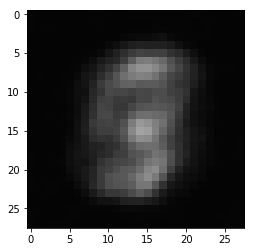

In [3]:
meta_net = Siren(in_features=2, out_features=1, hidden_features=128, hidden_layers=2)
meta_net.load_state_dict(torch.load('output/meta_net.pt'))
meta_net.cuda()

imshow(meta_net(coords).detach().reshape(1, 28, 28).cpu())

In [4]:
meta_params = torch.cat([v.flatten() for v in meta_net.parameters()])

c_model = nn.Sequential(
    nn.Linear(meta_params.shape[0], 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)
c_model.cuda()

c_optimizer = torch.optim.Adam(c_model.parameters(), lr=1e-3)

In [5]:
print_every = 1000
running_loss = 0
break_at = 10000

for i, [images, labels] in enumerate(data.train_loader, 0):
    net = meta_net.clone()
    optimizer = torch.optim.SGD(net.parameters(), lr=inner_lr)
    target = images[0].reshape(-1, 1).cuda()
    
    # fit to image
    for j in range(optim_steps):
        y = net(coords)
        loss = image_loss_fn(y, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # fit to class
    x = (torch.cat([v.detach().flatten() for v in net.parameters()]) - meta_params).unsqueeze(0)
    target = labels.cuda()
    y = c_model(x)
    loss = class_loss_fn(y, target)
    c_optimizer.zero_grad()
    loss.backward()
    c_optimizer.step()
    running_loss += loss.item()
    
    if (i + 1) % print_every == 0:
        print(f'[{i + 1} / {min(break_at, len(data.train_loader))}], loss: {running_loss / print_every}')
        running_loss = 0
    
    if i + 1 == break_at:
        break

torch.save(c_model.state_dict(), 'output/c_model.pt')

print ('Finished')

[1000 / 10000], loss: 1.342187595815165
[2000 / 10000], loss: 0.6401899144402123
[3000 / 10000], loss: 0.48276590961861077
[4000 / 10000], loss: 0.4870504262665854
[5000 / 10000], loss: 0.4288519535323867
[6000 / 10000], loss: 0.42892770556734466
[7000 / 10000], loss: 0.35494062229503104
[8000 / 10000], loss: 0.3599475266253503
[9000 / 10000], loss: 0.31653540969270577
[10000 / 10000], loss: 0.3399554141372355
Finished


In [6]:
print_every = 1000
break_at = 10000
correct = 0
total = 0

for i, [images, labels] in enumerate(data.test_loader, 0):
    net = meta_net.clone()
    optimizer = torch.optim.SGD(net.parameters(), lr=inner_lr)
    target = images[0].reshape(-1, 1).cuda()

    # fit to image
    for j in range(optim_steps):
        y = net(coords)
        loss = image_loss_fn(y, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # predict class
    with torch.no_grad():
        x = (torch.cat([v.detach().flatten() for v in net.parameters()]) - meta_params).unsqueeze(0)
        target = labels.cuda()
        y = c_model(x)
        _, predicted = torch.max(y, 1)
        correct += (predicted == target).sum().item()
        total += labels.size(0)

    if (i + 1) % print_every == 0:
        print(f'[{i + 1} / {min(break_at, len(data.test_loader))}]')

    if i + 1 == break_at:
        break

print(f'Accuracy on first {break_at}: {(100 * correct / total):.2f}%')

[1000 / 10000]
[2000 / 10000]
[3000 / 10000]
[4000 / 10000]
[5000 / 10000]
[6000 / 10000]
[7000 / 10000]
[8000 / 10000]
[9000 / 10000]
[10000 / 10000]
Accuracy on first 10000: 90.80%
